[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Laboratorio 3. Entrenamiento con la red preentrenada NFNet (Normalizer-Free Network)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. CONFIGURAR LAS TRANSFORMACIONES Y CARGAR EL DATASET

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Ruta al dataset en Google Drive
data_dir = '/content/drive/MyDrive/SIS 421/LAB2/dataset_plantas'

# Transformaciones: Redimensionar si es necesario. Convertir a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Cargar el dataset con las transformaciones
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividir en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, test_size])

# Crear DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# Imprimir dimensiones
print(f"Total de imágenes en el dataset: {full_dataset}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar los TAMAÑOS DEL PRIMER BATCH en los DataLoaders. batch_size=16
for images, labels in trainloader:
    print("PRIMER BATCH TRAINLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")

    break  # Sólo en el primer batch

for images, labels in testloader:
    print("PRIMER BATCH TESTLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")
    break  # Sólo el primer batch

# Imprimir las Clases
classes = full_dataset.classes
print("CLASES")
print(classes)

Total de imágenes en el dataset: Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/SIS 421/LAB2/dataset_plantas
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000
PRIMER BATCH TRAINLOADER
Tamaño de imágenes: torch.Size([16, 3, 224, 224])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
PRIMER BATCH TESTLOADER
Tamaño de imágenes: torch.Size([16, 3, 224, 224])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
CLASES
['laurel', 'limon', 'membrillo', 'olivo', 'papaya']


##2. VISUALIZACIÓN DE LAS IMÁGENES

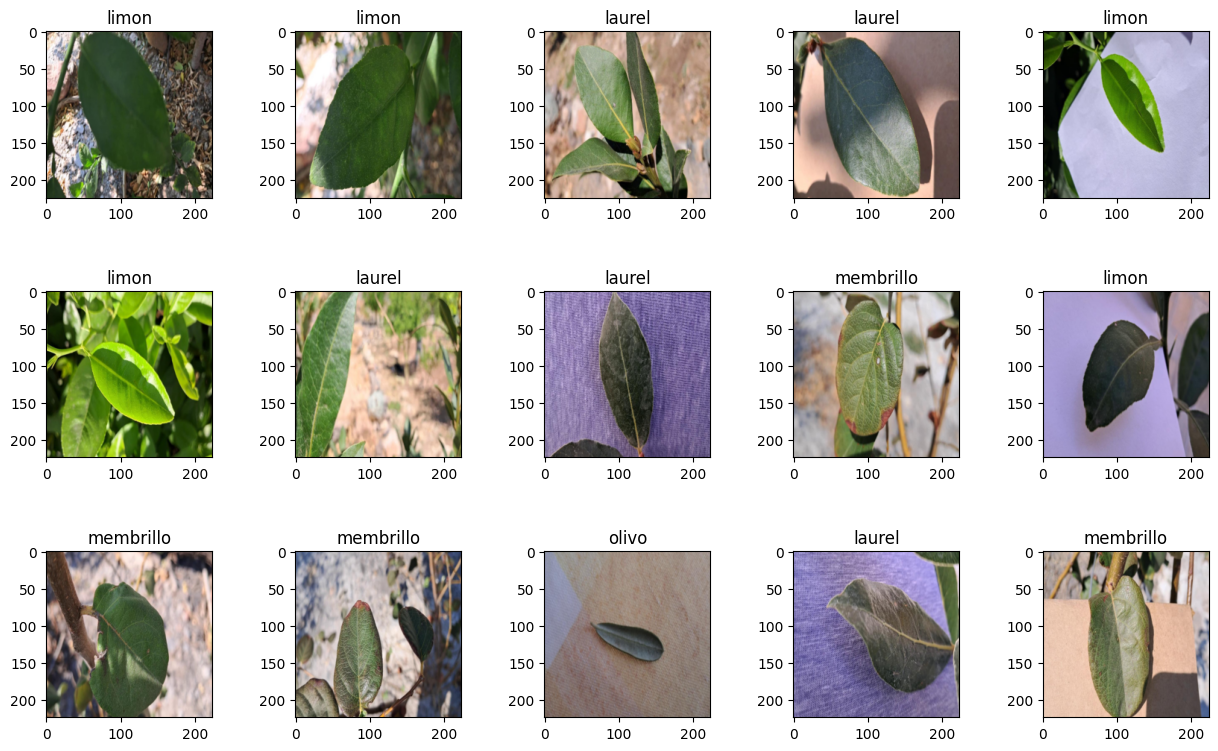

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()  # Convertir a numpy array
    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)
    plt.imshow(img)
    plt.axis('on')  # Activar los ejes para mostrar las dimensiones
    #plt.xlabel(f'Width: {img.shape[1]} px')
    #plt.ylabel(f'Height: {img.shape[0]} px')

r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))

for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]

        # Visualizar imagen
        imshow(img)
        plt.title(classes[label])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


##3. Modelo MNasNet1_3

In [4]:
import torchvision

# Descargar MnasNet1_3 preentrenado del paquete torchvision.models
mnasnet = torchvision.models.mnasnet1_3(pretrained=True)

# Imprimir la estructura del modelo
print(mnasnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [5]:
import torch
import torchvision

class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()

        # Descargar MnasNet1_3 preentrenado
        mnasnet = torchvision.models.mnasnet1_3(pretrained=pretrained)

        # Nos quedamos con todas las capas menos la última capa fully connected
        self.mnasnet = torch.nn.Sequential(*list(mnasnet.children())[:-1])  # Excluimos la última capa

        # Congelar las capas si freeze=True
        if freeze:
            for param in self.mnasnet.parameters():
                param.requires_grad = False

        # Añadir una nueva capa lineal para realizar la clasificación de las 5 clases
        self.fc = torch.nn.Linear(62720, 5)  # 62720 es el resultado de flatten(1280*7*7)

    def forward(self, x):
        x = self.mnasnet(x)                         # Aplicamos MnasNet
        x = x.view(x.size(0), -1)                   # Aplanamos la salida
        x = self.fc(x)                              # Pasamos la salida por la nueva capa fully connected
        return x

    def unfreeze(self):
        # Función para descongelar todas las capas
        for param in self.mnasnet.parameters():
            param.requires_grad = True


In [6]:
# INSTANCIAMOS NUESTRO MODELO
model_custom = ModelCustom(n_outputs=5, pretrained=True, freeze=False)

# PASAMOS UN TENSOR DE PRUEBA PARA VER QUE TODO FUNCIONA BIEN
# Dimensiones del tensor de prueba: [64, 3, 224, 224] (batch_size=64, 3 canales de color, tamaño de imagen 224x224)
test_tensor = torch.randn(64, 3, 224, 224)

# Obtenemos las predicciones
outputs = model_custom(test_tensor)

# Verificamos la forma de salida, debería ser [64, 5] porque hay 64 imágenes en el batch y 5 clases
print(outputs.shape)


torch.Size([64, 5])


##4. Funcion de entrenamiento

In [7]:
from tqdm import tqdm
import torch
import numpy as np

# Definir la función de entrenamiento para tu modelo custom basado en MnasNet1_3
def fit(model, dataloaders, epochs=5, lr=1e-2):  # FUNCIÓN DE ENTRENAMIENTO
    model.to(device)  # Mover el modelo al dispositivo (CPU o GPU)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Optimizador
    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida

    for epoch in range(1, epochs + 1):
        model.train()  # Modo de entrenamiento

        # Listas para almacenar pérdida y precisión en entrenamiento
        train_loss, train_acc = [], []

        # Barra de progreso para el entrenamiento
        bar = tqdm(dataloaders['train'])
        for batch in bar:
            X, y = batch  # Obtener los datos y etiquetas
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            optimizer.zero_grad()  # Limpiar los gradientes
            y_hat = model(X)  # Obtener las predicciones del modelo
            loss = criterion(y_hat, y)  # Calcular la pérdida

            loss.backward()  # Retropropagación
            optimizer.step()  # Actualizar los pesos del modelo

            # Guardar la pérdida y calcular precisión
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Barra de progreso para validación
        bar = tqdm(dataloaders['test'])
        val_loss, val_acc = [], []
        model.eval()  # Modo de evaluación

        with torch.no_grad():  # No calcular gradientes durante la validación
            for batch in bar:
                X, y = batch  # Obtener los datos y etiquetas de prueba
                X, y = X.to(device), y.to(device)

                y_hat = model(X)  # Obtener las predicciones
                loss = criterion(y_hat, y)  # Calcular la pérdida
                val_loss.append(loss.item())

                # Calcular precisión
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Imprimir estadísticas de la época
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


##Definimos nuestros dataloaders

###Entrenamos desde cero con MNasNet1_3.
Descargamos MNasNet1_3 sin los pesos preentrenados.


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Asegúrate de que 'trainloader' y 'testloader' estén definidos como en tu dataset

dataloaders = {
    'train': trainloader,
    'test': testloader
}


In [10]:
# Instancia tu modelo con MnasNet1_3
model_custom = ModelCustom()

# Entrenar el modelo
fit(model_custom, dataloaders, epochs=10, lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
val_loss 1.63654 val_acc 0.20650: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


Epoch 1/10 loss 1.44229 val_loss 1.63654 acc 0.52787 val_acc 0.20650


val_loss 1.67053 val_acc 0.20650: 100%|██████████| 125/125 [00:21<00:00,  5.82it/s]


Epoch 2/10 loss 0.71368 val_loss 1.67053 acc 0.75200 val_acc 0.20650


val_loss 1.73452 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Epoch 3/10 loss 0.54617 val_loss 1.73452 acc 0.81225 val_acc 0.20650


val_loss 1.72416 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Epoch 4/10 loss 0.34061 val_loss 1.72416 acc 0.87775 val_acc 0.20650


val_loss 1.82205 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Epoch 5/10 loss 0.24180 val_loss 1.82205 acc 0.91487 val_acc 0.20650


val_loss 2.05187 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Epoch 6/10 loss 0.14948 val_loss 2.05187 acc 0.94963 val_acc 0.20650


val_loss 1.98970 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.88it/s]


Epoch 7/10 loss 0.12002 val_loss 1.98970 acc 0.95888 val_acc 0.20650


val_loss 1.80277 val_acc 0.20650: 100%|██████████| 125/125 [00:19<00:00,  6.52it/s]


Epoch 8/10 loss 0.11935 val_loss 1.80277 acc 0.95962 val_acc 0.20650


val_loss 2.05280 val_acc 0.20650: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]


Epoch 9/10 loss 0.09248 val_loss 2.05280 acc 0.96788 val_acc 0.20650


val_loss 1.93741 val_acc 0.20650: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]

Epoch 10/10 loss 0.07196 val_loss 1.93741 acc 0.97413 val_acc 0.20650


##5. Transfer learning, utilizando los pesos pre-entrenados de MNasNet1_3

In [11]:
model_custom = ModelCustom(pretrained=True, freeze=True)   # AHORA DEFINIMOS NUESTRO MODELO PERO CON LOS PESOS PREENTRENADOS, ÉSTA RED YA SABE VER
                                                      # PONEMOS freeze A True, NO VAMOS A ENTRENAR resnet, SOLO VAMOS A ENTRENAR LA ÚLTIMA CAPA
fit(model_custom, dataloaders)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.50934 val_acc 0.88750: 100%|██████████| 125/125 [00:19<00:00,  6.58it/s]


Epoch 1/5 loss 0.26143 val_loss 0.50934 acc 0.93963 val_acc 0.88750


val_loss 0.33511 val_acc 0.91850: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]


Epoch 2/5 loss 0.06063 val_loss 0.33511 acc 0.98600 val_acc 0.91850


val_loss 0.36171 val_acc 0.92300: 100%|██████████| 125/125 [00:18<00:00,  6.91it/s]


Epoch 3/5 loss 0.03206 val_loss 0.36171 acc 0.99125 val_acc 0.92300


val_loss 0.14163 val_acc 0.97200: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]


Epoch 4/5 loss 0.02408 val_loss 0.14163 acc 0.99362 val_acc 0.97200


val_loss 0.15776 val_acc 0.96400: 100%|██████████| 125/125 [00:17<00:00,  6.97it/s]

Epoch 5/5 loss 0.01880 val_loss 0.15776 acc 0.99513 val_acc 0.96400


##6. Primera forma Fine Tuning

In [12]:
model_custom = ModelCustom(pretrained=True, freeze=False)   # pretrained=True PARA QUE DESCARGUE LOS PESOS. freeze=False PARA QUE HAGA TODO EL ENTRENAMIENO.
                                                            # PERO TODA LA RED ESTÁ INICIALIZADA CON LOS PESOS DE MNasnet1_3, POR TANTO YA SABE VER:
fit(model_custom, dataloaders)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 3.36052 val_acc 0.34500: 100%|██████████| 125/125 [00:17<00:00,  6.95it/s]


Epoch 1/5 loss 0.11839 val_loss 3.36052 acc 0.96462 val_acc 0.34500


val_loss 2.11455 val_acc 0.64500: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


Epoch 2/5 loss 0.01345 val_loss 2.11455 acc 0.99562 val_acc 0.64500


val_loss 1.55905 val_acc 0.69400: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


Epoch 3/5 loss 0.00537 val_loss 1.55905 acc 0.99862 val_acc 0.69400


val_loss 0.66549 val_acc 0.84400: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Epoch 4/5 loss 0.00221 val_loss 0.66549 acc 0.99913 val_acc 0.84400


val_loss 1.02951 val_acc 0.81350: 100%|██████████| 125/125 [00:19<00:00,  6.39it/s]


Epoch 5/5 loss 0.00252 val_loss 1.02951 acc 0.99887 val_acc 0.81350


##7. Segunda forma de Fine Tuning

In [13]:
model_o = ModelCustom(pretrained=True, freeze=True)     # INICIALIZAR EL MODELO DESCARGANDO LOS PESOS PERO CONGELANDO LA RED
fit(model_o, dataloaders)                                # LA ENTRENAMOS DURANTE UNAS CUANTAS EPOCHS
model_o.unfreeze()                                      # DESCONGELAMOS LA RED DESPUÉS DE HABER ENTRENADO UN POQUITO LA RED PARA ENTRENARLA TODA LA RED CON UN lr UN POCO MÁS PEQUEÑO
fit(model_o, dataloaders, lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.38595 val_acc 0.90300: 100%|██████████| 125/125 [00:25<00:00,  4.92it/s]


Epoch 1/5 loss 0.29727 val_loss 0.38595 acc 0.93550 val_acc 0.90300


val_loss 0.21601 val_acc 0.94250: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


Epoch 2/5 loss 0.05391 val_loss 0.21601 acc 0.98575 val_acc 0.94250


val_loss 0.29330 val_acc 0.93550: 100%|██████████| 125/125 [00:18<00:00,  6.90it/s]


Epoch 3/5 loss 0.03967 val_loss 0.29330 acc 0.99162 val_acc 0.93550


val_loss 0.24408 val_acc 0.95050: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


Epoch 4/5 loss 0.03371 val_loss 0.24408 acc 0.99275 val_acc 0.95050


val_loss 0.13508 val_acc 0.97350: 100%|██████████| 125/125 [00:18<00:00,  6.72it/s]


Epoch 5/5 loss 0.01933 val_loss 0.13508 acc 0.99462 val_acc 0.97350


val_loss 0.09797 val_acc 0.98000: 100%|██████████| 125/125 [00:23<00:00,  5.41it/s]


Epoch 1/5 loss 0.01632 val_loss 0.09797 acc 0.99613 val_acc 0.98000


val_loss 0.09061 val_acc 0.98000: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Epoch 2/5 loss 0.01453 val_loss 0.09061 acc 0.99600 val_acc 0.98000


val_loss 0.07008 val_acc 0.98100: 100%|██████████| 125/125 [00:17<00:00,  7.01it/s]


Epoch 3/5 loss 0.01455 val_loss 0.07008 acc 0.99675 val_acc 0.98100


val_loss 0.07549 val_acc 0.98100: 100%|██████████| 125/125 [00:18<00:00,  6.85it/s]


Epoch 4/5 loss 0.00748 val_loss 0.07549 acc 0.99713 val_acc 0.98100


val_loss 0.07665 val_acc 0.98200: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]

Epoch 5/5 loss 0.00974 val_loss 0.07665 acc 0.99738 val_acc 0.98200


##8. Tercera forma de Fine Tuning
Entrenar con diferentes learning rate las diferentes partes del modelo.

In [14]:
optimizer = torch.optim.Adam([
    {'params': model_o.mnasnet.parameters(), 'lr': 1e-4},      # EJEMPLO EL resnet QUE YA ESTÁ ENTRENADO LO VAMOS A ENTRENAR AON UN lr=0000.1
    {'params': model_o.fc.parameters(), 'lr': 1e-3}           # LA fc PODEMOS ENTRENAR CON UN lr UN POCO MÁS ALTO PARA LLEGAR A MEJORES SOLUCIONES MÁS RÁPIDO
])

In [15]:
from tqdm import tqdm
import torch
import numpy as np

def fit(model, dataloaders, epochs=5, lr_backbone=1e-4, lr_fc=1e-3):  # FUNCIÓN DE ENTRENAMIENTO CON FINE-TUNING
    model.to(device)

    # Optimizer con diferentes learning rates para cada parte del modelo
    optimizer = torch.optim.Adam([
        {'params': model.mnasnet.parameters(), 'lr': lr_backbone},  # Fine-tuning del backbone de MnasNet con un LR más bajo
        {'params': model.fc.parameters(), 'lr': lr_fc}  # Fine-tuning de la capa final (fully connected) con un LR más alto
    ])

    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida

    for epoch in range(1, epochs+1):
        model.train()  # Modo entrenamiento

        # Listas para almacenar la pérdida y precisión durante el entrenamiento
        train_loss, train_acc = [], []

        # Barra de progreso para el entrenamiento
        bar = tqdm(dataloaders['train'])
        for batch in bar:
            X, y = batch  # Obtener los datos y etiquetas
            X, y = X.to(device), y.to(device)  # Mover datos a GPU o CPU

            optimizer.zero_grad()  # Limpiar gradientes
            y_hat = model(X)  # Obtener las predicciones
            loss = criterion(y_hat, y)  # Calcular la pérdida

            loss.backward()  # Retropropagación
            optimizer.step()  # Actualizar los pesos

            train_loss.append(loss.item())  # Almacenar la pérdida
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)  # Calcular la precisión
            train_acc.append(acc)  # Almacenar la precisión

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Barra de progreso para la validación
        bar = tqdm(dataloaders['test'])
        val_loss, val_acc = [], []

        model.eval()  # Modo de evaluación
        with torch.no_grad():  # Desactivar cálculo de gradientes
            for batch in bar:
                X, y = batch  # Obtener los datos y etiquetas de prueba
                X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

                y_hat = model(X)  # Obtener predicciones
                loss = criterion(y_hat, y)  # Calcular la pérdida
                val_loss.append(loss.item())  # Almacenar la pérdida

                # Calcular la precisión
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)  # Almacenar la precisión

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Imprimir estadísticas de la época
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [16]:
# Dataloaders con 'trainloader' y 'testloader'
dataloaders = {
    'train': trainloader,
    'test': testloader
}

# Instanciar el modelo personalizado basado en MnasNet1_3
model_custom = ModelCustom(n_outputs=5, pretrained=True, freeze=False)

# Entrenar el modelo con fine-tuning usando diferentes learning rates
fit(model_custom, dataloaders, epochs=10, lr_backbone=1e-4, lr_fc=1e-3)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 9.95076 val_acc 0.62450: 100%|██████████| 125/125 [00:21<00:00,  5.82it/s]


Epoch 1/10 loss 0.14845 val_loss 9.95076 acc 0.95925 val_acc 0.62450


val_loss 6.52842 val_acc 0.74450: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Epoch 2/10 loss 0.02613 val_loss 6.52842 acc 0.99350 val_acc 0.74450


val_loss 15.48383 val_acc 0.61400: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Epoch 3/10 loss 0.03140 val_loss 15.48383 acc 0.99325 val_acc 0.61400


val_loss 7.87290 val_acc 0.84650: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Epoch 4/10 loss 0.05846 val_loss 7.87290 acc 0.99013 val_acc 0.84650


val_loss 14.45094 val_acc 0.75400: 100%|██████████| 125/125 [00:17<00:00,  6.97it/s]


Epoch 5/10 loss 0.04101 val_loss 14.45094 acc 0.99375 val_acc 0.75400


val_loss 10.47230 val_acc 0.82250: 100%|██████████| 125/125 [00:17<00:00,  7.09it/s]


Epoch 6/10 loss 0.02650 val_loss 10.47230 acc 0.99475 val_acc 0.82250


val_loss 3.99650 val_acc 0.90300: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]


Epoch 7/10 loss 0.04053 val_loss 3.99650 acc 0.99400 val_acc 0.90300


val_loss 3.72811 val_acc 0.91400: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]


Epoch 8/10 loss 0.02977 val_loss 3.72811 acc 0.99475 val_acc 0.91400


val_loss 8.43095 val_acc 0.85500: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


Epoch 9/10 loss 0.05354 val_loss 8.43095 acc 0.99400 val_acc 0.85500


val_loss 16.36963 val_acc 0.76350: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]

Epoch 10/10 loss 0.04203 val_loss 16.36963 acc 0.99487 val_acc 0.76350
